Nodal Displacments: [ 2.32923748e-05 -1.39754249e-04]
Stresses: [223.60679774997902, -111.8033988749895]
Frequencies: [1592.2346773 1592.2346773]
Displacment Magnitude: 0.00014


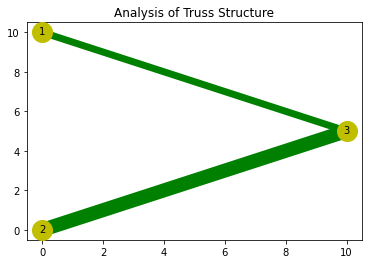

In [2]:
import numpy as np 
from numpy.linalg import norm
from scipy.linalg import eigh
import matplotlib.pyplot as plt 

def setup():
	# define the coordinate system
	x_axis = np.array([1,0])
	y_axis = np.array([0,1])

	# define the model
	nodes              = { 1:[0,10], 2:[0,0], 3:[10,5]}
	degrees_of_freedom = { 1:[1,2], 2:[3,4], 3:[5,6] }
	elements 		   = { 1:[1,3], 2:[2,3] }
	restrained_dofs    = [1, 2, 3, 4]
	forces             = { 1:[0,0], 2:[0,0], 3:[0,-200] }

	# material properties - AISI 1095 Carbon Steel (Spring Steel)
	densities   = {1:0.284, 2:0.284}
	stiffnesses = {1:30.0e6, 2:30.0e6}
	# geometric properties
	areas = {1:1.0, 2:2.0}

	ndofs = 2 * len(nodes)

	# assertions
	assert len(densities) == len(elements) == len(stiffnesses) == len(areas)
	assert len(restrained_dofs) < ndofs
	assert len(forces) == len(nodes)

	return {  'x_axis':x_axis, 'y_axis':y_axis, 'nodes':nodes, 'degrees_of_freedom':degrees_of_freedom,   \
	      	  'elements':elements, 'restrained_dofs':restrained_dofs, 'forces':forces, 'ndofs':ndofs,     \
	      	  'densities':densities, 'stiffnesses':stiffnesses, 'areas':areas }

def plot_nodes(nodes):
	x = [i[0] for i in nodes.values()]
	y = [i[1] for i in nodes.values()]
	size = 400
	offset = size/4000.
	plt.scatter(x, y, c='y', s=size, zorder=5)
	for i, location in enumerate(zip(x,y)):
		plt.annotate(i+1, (location[0]-offset, location[1]-offset), zorder=10)

def points(element, properties):
	elements = properties['elements']
	nodes = properties['nodes']
	degrees_of_freedom = properties['degrees_of_freedom']

	# find the nodes that the lements connects
	fromNode = elements[element][0]
	toNode = elements[element][1]

	# the coordinates for each node
	fromPoint = np.array(nodes[fromNode])
	toPoint = np.array(nodes[toNode])

	# find the degrees of freedom for each node
	dofs = degrees_of_freedom[fromNode]
	dofs.extend(degrees_of_freedom[toNode])
	dofs = np.array(dofs)

	return fromPoint, toPoint, dofs

def draw_element(fromPoint, toPoint, element, areas):
	x1 = fromPoint[0]
	y1 = fromPoint[1]
	x2 = toPoint[0]
	y2 = toPoint[1]
	plt.plot([x1, x2], [y1, y2], color='g', linestyle='-', linewidth=7*areas[element], zorder=1)

def direction_cosine(vec1, vec2):
	return np.dot(vec1,vec2) / (norm(vec1) * norm(vec2))

def rotation_matrix(element_vector, x_axis, y_axis):
	# find the direction cosines
	x_proj = direction_cosine(element_vector, x_axis)
	y_proj = direction_cosine(element_vector, y_axis)
	return np.array([[x_proj,y_proj,0,0],[0,0,x_proj,y_proj]])

def get_matrices(properties):
	# construct the global mass and stiffness matrices
	ndofs    = properties['ndofs']
	nodes    = properties['nodes']
	elements = properties['elements']
	forces   = properties['forces']
	areas    = properties['areas']
	x_axis   = properties['x_axis']
	y_axis   = properties['y_axis']

	plot_nodes(nodes)

	M = np.zeros((ndofs,ndofs))
	K = np.zeros((ndofs,ndofs))

	for element in elements:
		# find the element geometry
		fromPoint, toPoint, dofs = points(element, properties)
		element_vector = toPoint - fromPoint

		draw_element(fromPoint, toPoint, element, areas)   # display the element

		# find element mass and stiffness matrices
		length = norm(element_vector)
		rho    = properties['densities'][element]
		area   = properties['areas'][element]
		E      = properties['stiffnesses'][element]

		Cm = rho * area * length / 6.0
		Ck = E * area / length

		m = np.array([[2,1],[1,2]]) 
		k = np.array([[1,-1],[-1,1]])

		# find rotated mass and stiffness element matrices
		tau = rotation_matrix(element_vector, x_axis, y_axis)
		m_r = tau.T.dot(m).dot(tau)
		k_r = tau.T.dot(k).dot(tau)

		# change from element to global coordinates
		index = dofs-1
		B = np.zeros((4,ndofs))
		for i in range(4):
			B[i,index[i]] = 1.0
		M_rG = B.T.dot(m_r).dot(B)
		K_rG = B.T.dot(k_r).dot(B)

		M += Cm * M_rG
		K += Ck * K_rG

	# construct the force vector
	F = []
	for f in forces.values():
		F.extend(f)
	F = np.array(F)

	# remove the restrained dofs
	remove_indices = np.array(properties['restrained_dofs']) - 1
	for i in [0,1]:
		M = np.delete(M, remove_indices, axis=i)
		K = np.delete(K, remove_indices, axis=i)		

	F = np.delete(F, remove_indices)

	return M, K, F

def get_stresses(properties, X):
	x_axis   = properties['x_axis']
	y_axis   = properties['y_axis']
	elements = properties['elements']
	E 		 = properties['stiffnesses']

	# find the stresses in each member
	stresses = []
	for element in elements:
		# find the element geometry
		fromPoint, toPoint, dofs = points(element, properties)
		element_vector = toPoint - fromPoint

		# find rotation matrix
		tau = rotation_matrix(element_vector, x_axis, y_axis)
		global_displacements = np.array([0,0,X[0],X[1]])
		q = tau.dot(global_displacements)

		# calculate the strains and stresses
		strain = (q[1] - q[0]) / norm(element_vector)
		stress = E[element] * strain
		stresses.append(stress)

	return stresses

def show_results(X, stresses, frequencies):
	print('Nodal Displacments:', X)
	print('Stresses:', stresses)
	print('Frequencies:', frequencies)
	print('Displacment Magnitude:', round(norm(X),5))

def main():
	# problem setup
	properties = setup()

	# determine the global matrices
	M, K, F = get_matrices(properties)

	# find the natural frequencies
	evals, evecs = eigh(K,M)
	frequencies = np.sqrt(evals)

	# calculate the static displacement of each element
	X = np.linalg.inv(K).dot(F)

	# determine the stresses in each element
	stresses = get_stresses(properties, X)

	# output results
	show_results(X, stresses, frequencies)

	plt.title('Analysis of Truss Structure')
	plt.show()



if __name__ == '__main__':
	main()
